In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [3]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0    
nfreq = 1

In [4]:
# Sx  = 20    
# Sy = 20
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

tpml = 0.4

boundary_layers = [
    mp.PML(tpml, direction=mp.Y),
    mp.PML(tpml, direction=mp.X)
]


tag_bot   = 0.5
tsio2     = 4
tag_side  = 4
design_region_height = 0.5
monitor_position     = 0.5 * 2
monitor_blank        = 0.5 * 0.1

width_ag       = 0.2
width_sio2     = 2
width_bot_ag   = round(width_ag + width_sio2 + width_ag, 2)
design_region_width  = round(width_bot_ag, 3)

Sx = 20
Sy = 20
cell_size   = mp.Vector3(Sx, Sy)

y_bottom = -Sy/2 + tpml
center_y_ag        = y_bottom + tag_bot/2
center_y_sio2      = y_bottom + tag_bot + tsio2/2
center_y_design    = y_bottom + tag_bot + tsio2 + design_region_height/2
center_y_monitor_position   = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position    = y_bottom + tag_bot + 5/fcen  # 예시
center_Ag_x_offset = design_region_width/2 - width_ag/2

Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1

geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side Ag layers
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_offset, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3( center_Ag_x_offset, center_y_sio2, 0)
    ),
]

In [26]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [27]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

In [28]:
r = 20           # 20 μm 떨어진 곳

inner_x = Sx - 2*tpml
inner_y = Sy - 2*tpml
y_off = 0.5 * inner_y - 2/resolution

dft_line = sims[0].add_dft_fields(
    [mp.Ez],        # 측정할 성분
    fcen, 0, 1,     # 중심주파수, 대역폭(df=0), 샘플수=1
    
    center=mp.Vector3(0, y_off, 0),
    size  = mp.Vector3(inner_x, 0, 0)
    
)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000405788 s
Working in 2D dimensions.
Computational cell is 20 x 20 x 0 with resolution 50
time for set_epsilon = 2.07042 s
lorentzian susceptibility: frequency=16.365, gamma=1.95106
lorentzian susceptibility: frequency=7.32593, gamma=0.738804
lorentzian susceptibility: frequency=6.60165, gamma=0.052426
lorentzian susceptibility: frequency=3.61417, gamma=0.364563
lorentzian susceptibility: frequency=0.658148, gamma=3.13427
drude susceptibility: frequency=1e-10, gamma=0.0387146
-----------
on time step 542 (time=5.42), 0.00739292 s/step
run 0 finished at t = 9.34 (934 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000494003 s
Working in 2D dimensions.
Computational cell is 20 x 20 x 0 with resolution 50
     block, center = (0,-9.35,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (

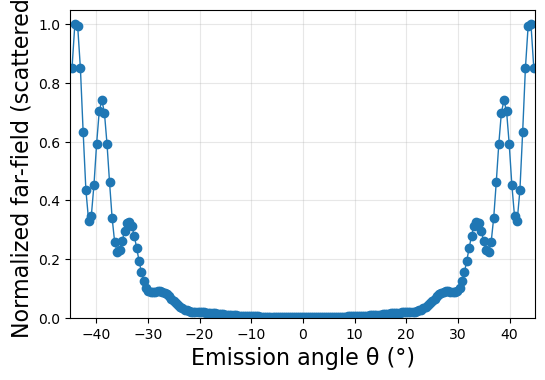

In [29]:
margin   = 0.3
line_len = Sx - 2*tpml - 2*margin
assert line_len > 0, "line_len<=0 → Sx/tpml/margin 값을 확인하세요."

y_far = +Sy/2 - tpml - 0.5*margin                      # 위쪽 공기층 안쪽
far_vol = mp.Volume(center=mp.Vector3(0, y_far, 0),
                    size=mp.Vector3(line_len, 0, 0))

# 1) 참조 시뮬레이션 (구조 없음 → 입사장만 측정)
def _make_source(center):
    return [mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
                      component=mp.Ez, center=center)]

src_center = mp.Vector3(0, center_y_source_position, 0)  # 네가 위에서 쓴 소스 위치와 동일하게

sim_ref = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=[],                           # ★ 구조 없음
    sources=_make_source(src_center),
    default_material=mp.Medium(index=1),
    extra_materials=[Ag],
    k_point=k0
)
dft_far_ref = sim_ref.add_dft_fields([mp.Ez], fcen, 0, 1,
                                     center=far_vol.center, size=far_vol.size)
sim_ref.run(until_after_sources=mp.stop_when_dft_decayed(fcen, 50, 1e-9))
Ez_ref = sim_ref.get_dft_array(dft_far_ref, mp.Ez, 0)     # complex, shape ≈ N
sim_ref.reset_meep()

# 2) 대상 시뮬레이션 (네 geometry 그대로)
sim_obj = sims[0]                                        # 위에서 만든 첫 번째 Simulation
dft_far_obj = sim_obj.add_dft_fields([mp.Ez], fcen, 0, 1,
                                     center=far_vol.center, size=far_vol.size)
sim_obj.run(until_after_sources=mp.stop_when_dft_decayed(fcen, 50, 1e-9))
Ez_tot = sim_obj.get_dft_array(dft_far_obj, mp.Ez, 0)

# 3) 산란장 = 총장 − 참조 (N2F가 산란장을 쓰는 것과 동일 기준)
Ez_sc = Ez_tot - Ez_ref

# 4) 라인 DFT → 각도 스펙트럼 (윈도잉/제로패딩/전파성분/각도변환)
N  = Ez_sc.size
dx = 1.0 / resolution

window = np.hanning(N)           # 끝단 누설 감소
pad    = 4                       # 제로패딩 배수(각도 해상도↑)

Ek = np.fft.fftshift(np.fft.fft(Ez_sc * window, n=N*pad)) * dx
kx = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(N*pad, d=dx))

n_bg   = 1.0                     # 모니터가 있는 배경 굴절률(공기=1)
k0_med = 2*np.pi*fcen * n_bg     # 매질 내 파수
prop   = np.abs(kx) <= (k0_med + 1e-12)   # 에반슨트 제거
kx, Ek = kx[prop], Ek[prop]

theta = np.arcsin(kx / k0_med)   # [rad], 법선(y축) 기준 방출 각

# 5) 원방 Poynting 플럭스 계산 (정확)
# 2D TM(Ez) 평면파 관계: Hx = (ky/ω) Ez,  Hy = -(kx/ω) Ez  (μ=1, c=1 단위)
omega = 2*np.pi*fcen
ky = np.sqrt(np.maximum(k0_med**2 - kx**2, 0.0))   # 위쪽으로 전파 → +부호

Hx = (ky/omega) * Ek
Hy = -(kx/omega) * Ek

# Poynting: S = Re(E × H*)  → Sx = -Re(Ez Hy*),  Sy = Re(Ez Hx*)
Sx = -np.real(np.conj(Ek) * Hy)
Sy =  np.real(np.conj(Ek) * Hx)

# 파워를 전파 방향(kx,ky)으로 투영 (정규화에는 상수배 무관)
Sang = (Sx * (kx/k0_med) + Sy * (ky/k0_med))
Sang = np.maximum(Sang, 0.0)     # 수치 잡음으로 음수 생기면 컷

# 6) 정규화/플롯
theta_deg = np.degrees(theta)
mask      = (theta_deg >= -45) & (theta_deg <= 45)  # 관심 각도만 별도 정규화 (옵션)

theta_plot = theta_deg[mask]
P_plot     = Sang[mask]
pattern    = P_plot / (np.max(P_plot) + 1e-18)

plt.figure(figsize=(6,4))
plt.plot(theta_plot, pattern, marker='o', lw=1)
plt.xlim(-45, 45); plt.ylim(0, 1.05)
plt.xlabel("Emission angle θ (°)", fontsize=fontlabel)
plt.ylabel("Normalized far-field (scattered)", fontsize=fontlabel)
plt.grid(True, alpha=0.3)
plt.show()

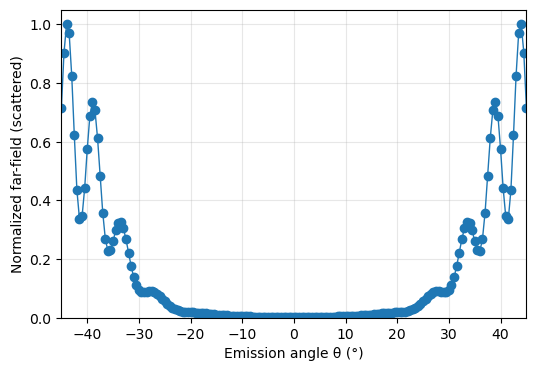

In [39]:
# FFT 이후: Ek, kx, k0_med, ... 준비되어 있다고 가정

theta = np.arcsin(kx / k0_med)
theta_deg = np.degrees(theta)

# θ 균일 그리드(예: -45~45도)
th_grid = np.linspace(-45, 45, 181)
I_kx = np.abs(Ek)**2

# per-angle 파워: |Ek|^2 를 θ로 보간 (야코비안 보정 불필요)
I_th = np.interp(th_grid, theta_deg, I_kx, left=0.0, right=0.0)
pattern = I_th / (np.max(I_th) + 1e-18)

plt.plot(th_grid, pattern, 'o-', lw=1)
plt.xlim(-45, 45); plt.ylim(0, 1.05)
plt.xlabel("Emission angle θ (°)")
plt.ylabel("Normalized far-field (scattered)")
plt.grid(True, alpha=0.3)


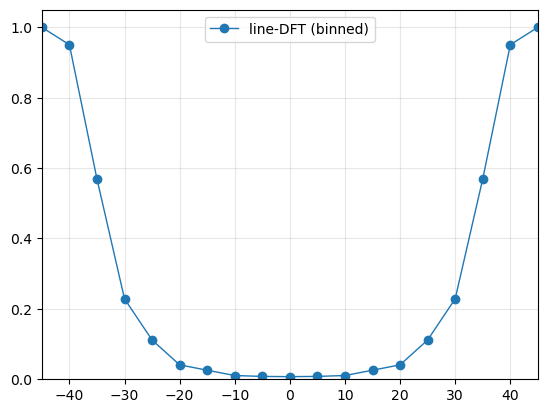

In [40]:
# N2F에서 쓴 샘플 각도들(예): (너가 쓴 배열로 바꿔)
theta_n2f = np.linspace(-45, 45, 19)  # 예시
dth = (theta_n2f[1]-theta_n2f[0])     # 균일 간격 가정

# kx축에서 대응 구간으로 적분 (kx = k0*sinθ)
kx_centers = k0_med * np.sin(np.radians(theta_n2f))
dk = k0_med * np.cos(np.radians(theta_n2f)) * np.radians(dth)   # dk = k0 cosθ dθ

# 라인-DFT는 kx 균일이므로, 각 중심 kx에 대해 폭=dk의 사다리꼴 적분
I_bin = []
for kxc, dkk in zip(kx_centers, dk):
    kL, kR = kxc - 0.5*dkk, kxc + 0.5*dkk
    mask = (kx >= kL) & (kx <= kR)
    # 적분(사다리꼴); |Ek|^2 dk → 각도 bin 파워
    val = np.trapz(np.abs(Ek[mask])**2, x=kx[mask]) if mask.any() else 0.0
    I_bin.append(val)

I_bin = np.array(I_bin)
I_bin /= (I_bin.max() + 1e-18)

plt.plot(theta_n2f, I_bin, 'o-', lw=1, label='line-DFT (binned)')
plt.legend(); plt.xlim(-45,45); plt.ylim(0,1.05); plt.grid(True, alpha=0.3)


In [21]:
margin   = 0.3
line_len = Sx - 2*tpml - 2*margin
assert line_len > 0, "line_len<=0 → Sx/tpml/margin 재확인"

y_far = +Sy/2 - tpml - 0.5*margin   # 공기층 안쪽
dft_far = sims[0].add_dft_fields(
    [mp.Ez],          # TM면 Ez, TE면 Hz
    fcen, 0, 1,
    center=mp.Vector3(0, y_far, 0),
    size=mp.Vector3(line_len, 0, 0)
)

     block, center = (0,-9.35,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-7.1,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

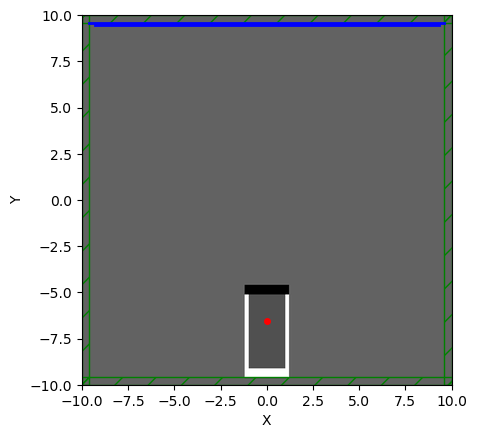

In [22]:
sims[0].plot2D()

In [23]:
sims[0].run(until_after_sources=mp.stop_when_dft_decayed())

# sims[0].run(until=300)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000365973 s
Working in 2D dimensions.
Computational cell is 20 x 20 x 0 with resolution 50
     block, center = (0,-9.35,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-7.1,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0

     block, center = (0,-9.35,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-7.1,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-7.1,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-4.85,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

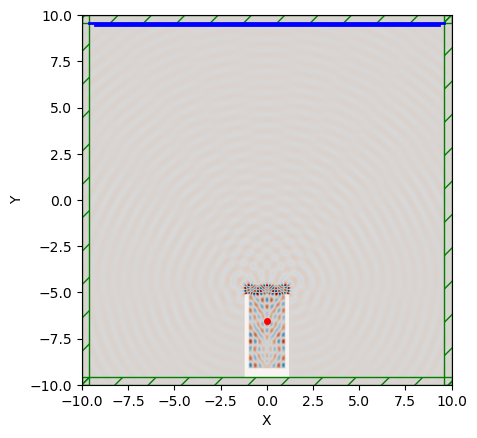

In [24]:
sims[0].plot2D(fields=mp.Ez,)

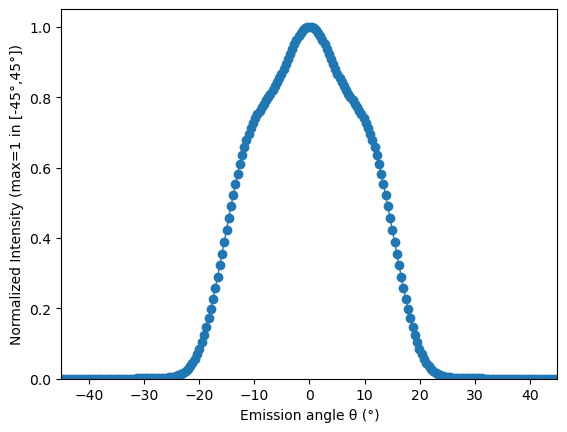

In [25]:
Ez = sims[0].get_dft_array(dft_far, mp.Ez, 0)  # shape ~ N
N  = Ez.size
dx = 1.0 / resolution

# 윈도잉 + 제로패딩
w   = np.hanning(N)
zf  = 4                      # 각도 샘플 세분화
EzW = Ez * w
Ek  = np.fft.fftshift(np.fft.fft(EzW, n=N*zf)) * dx
kx  = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(N*zf, d=dx))

# --- 4) 에반슨트 제거 + 각도 보정 ---
n_bg = 1.0
k0   = 2*np.pi*fcen*n_bg
prop = np.abs(kx) <= k0
kx   = kx[prop]
Ek   = Ek[prop]


theta = np.arcsin(kx / k0)       # [rad]
Ik    = np.abs(Ek)**2
P_th  = Ik * np.cos(theta)       # 전력의 각도 분포(법선 성분 가중)

pattern = P_th / (P_th.max() + 1e-18)
theta_deg = np.degrees(theta)

mask        = (theta_deg >= -45) & (theta_deg <= 45)
theta_plot  = theta_deg[mask]
P_plot      = P_th[mask]
pattern_norm= P_plot / (np.max(P_plot) + 1e-18)

plt.plot(theta_plot, pattern_norm, marker='o', lw=1)
plt.xlim(-45, 45)
plt.ylim(0, 1.05)
plt.xlabel("Emission angle θ (°)")
plt.ylabel("Normalized Intensity (max=1 in [-45°,45°])")
plt.show()